# Residual file and some useful routines
Austin, I've made a file for you containing the astrometric residuals for about 3000 "star flat" exposures from DECam. These are stored in a FITS file, in the form of 2 binary tables.  I can explain more about the FITS formats later if you want.  The Astropy package contains decent routines for interfacing with FITS data.  I will make use of that (you can get it via conda, see astropy.org) as well as the usual numpy and matplotlib stuff.

I will also load the `forAustin.py` file containing some routines that do useful things with these data, like plot them and calculate correlation functions in various ways.  I will demonstrate below.  For these you will need Mike Jarvis's treecorr package - `pip install treecorr` should do it.

In [1]:
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as pl
import forAustin as fa
%matplotlib inline

In [2]:
# First I will open the main data file, and show its contents
fits = pf.open('/data4/paper/fox/DES/austinFull.fits')
fits.info()

Filename: /data4/paper/fox/DES/austinFull.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Exposures     1 BinTableHDU     47   2820R x 19C   [1D, 1D, 4A, 1D, 8A, 1D, 1J, 1J, 1D, 1D, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  RESIDUALS     1 BinTableHDU     25   73818788R x 8C   [I, J, D, D, D, D, D, L]   


Above you can see that it contains three "extensions."  Extn [0] is empty; then [1] is a table holding information about each exposure.  Extn [2] is a huge table (74M rows) holding information about each stellar measurement in all the exposures.  Let's look at the latter first - what's in it?

In [3]:
fits[2].columns

ColDefs(
    name = 'exposure'; format = 'I'
    name = 'matchID'; format = 'J'
    name = 'u'; format = 'D'
    name = 'v'; format = 'D'
    name = 'dx'; format = 'D'
    name = 'dy'; format = 'D'
    name = 'measErr'; format = 'D'
    name = 'hasGaia'; format = 'L'
)

The columns contain the following:
* `exposure`: which exposure the measurement is from.  It's an index into the other table.
* `matchID`: Each star has a matchID.  So rows with the same matchID are different measures of the same star.
* `u,v`: the sky coordinates of the measurement (in degrees).
* `dx, dy`: the astrometric error of this measurement from our overall best guess for the position and proper motion of this star (in milliarcsec=mas)
* `measErr`: the shot noise error in this measurement.  It does not include the effects of atmospheric turbulence, just the contribution of noise in the image.
* `hasGaia`: set to True if the star's solution includes information from Gaia.

In [4]:
# Now the Exposure table (note that tables can be indexed
# by either their names or their numbers)
fits['Exposures'].columns

ColDefs(
    name = 'AIRMASS'; format = '1D'
    name = 'APCORR'; format = '1D'
    name = 'BAND'; format = '4A'
    name = 'DEC'; format = '1D'
    name = 'EPOCH'; format = '8A'
    name = 'EXPTIME'; format = '1D'
    name = 'FIELDNUMBER'; format = '1J'
    name = 'INSTRUMENTNUMBER'; format = '1J'
    name = 'MAGWEIGHT'; format = '1D'
    name = 'MJD'; format = '1D'
    name = 'NAME'; format = '8A'
    name = 'OBSX'; format = '1D'
    name = 'OBSY'; format = '1D'
    name = 'OBSZ'; format = '1D'
    name = 'RA'; format = '1D'
    name = 'syserrxx'; format = '1D'
    name = 'syserrxy'; format = '1D'
    name = 'syserryy'; format = '1D'
    name = 'WEIGHT'; format = '1D'
)

Of note here for the moment are:
* `BAND`: which filter was this image taken with?
* `RA, DEC`: where was the telescope pointed?
* `MJD`: when was it taken? (Modified Julian Date)
* `NAME`: Each DECam exposure is given an ID number.  This is a string telling you what that is, it's a unique identifier for exposures.

In [5]:
# Next I will use my routine to extract from this a smaller table 
# having just the information from one exposure:
single = fa.getExposure(fits, 424, polyOrder=3)
# Notice that this routine also lets me fit and remove a smoothly-varying
# (polynomial) function of u and v from the residuals.  Probably
# a good thing to do - we'll use our Gaussian Processes for smaller-scale
# stuff.
print('Number of measurements:',len(single))
print('Name of this exposure:',fits['Exposures'].data['NAME'][424])

Number of measurements: 17196
Name of this exposure: D228665


RMSx, RMSy, noise: 20.192861515096702 14.10183476206579 0.35560400078280097


/home/fortino/DESworkspace/forAustin.py:210: RuntimeWarning: invalid value encountered in true_divide
  sumxw = np.where( sumw > minWeight, sumxw / sumw, noData)
/home/fortino/DESworkspace/forAustin.py:211: RuntimeWarning: invalid value encountered in true_divide
  sumyw = np.where( sumw > minWeight, sumyw / sumw, noData)
/home/fortino/DESworkspace/forAustin.py:212: RuntimeWarning: divide by zero encountered in true_divide
  sumw = np.where( sumw > minWeight, 1./sumw, noData)
/home/fortino/DESworkspace/forAustin.py:213: RuntimeWarning: invalid value encountered in greater
  rmsx = np.std(sumxw[sumw>0.])
/home/fortino/DESworkspace/forAustin.py:214: RuntimeWarning: invalid value encountered in greater
  rmsy = np.std(sumyw[sumw>0.])
/home/fortino/DESworkspace/forAustin.py:215: RuntimeWarning: invalid value encountered in greater
  print('RMSx, RMSy, noise:', rmsx, rmsy, np.sqrt(np.mean(sumw[sumw>0.])))
/home/fortino/DESworkspace/forAustin.py:223: RuntimeWarning: invalid value encountered

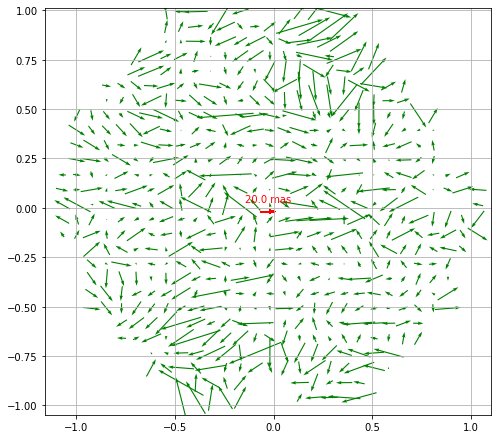

In [6]:
# The next routine will make a pretty graph of the residual pattern
# by binning the stars in 2d:
pl.figure(figsize=(8,8))
dx,dy,u,v, wt = fa.residInPixels(single, binpix=1024)

In the above you can see the outline of DECam.  The axis units are in degrees.  The arrows can be spaced more sparsely by increasing `binpix` (=DECam pixels per bin used to make one arrow).  The scale of the arrows can be altered using `scaleFudge`.

RMS of div: 32.32; curl: 21.40


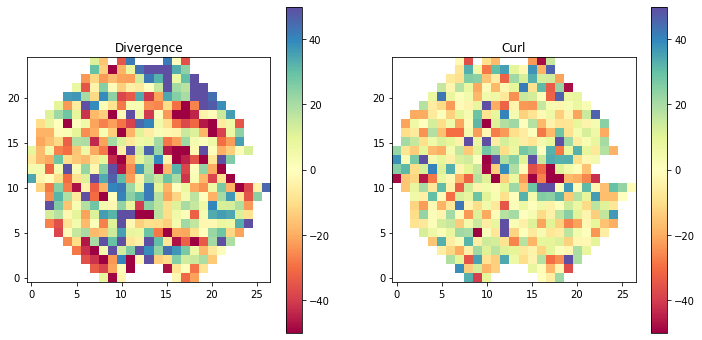

In [7]:
# This routine will take the numerical output of the above binning
# exercise and will calculate the div and curl of the vector field.
pl.figure(figsize=(12,6))
fa.ebPlot(dx,dy,u,v)
#This one does not look as perfect as the one in the paper - noisier!
#(and I think there are some other systematic errors hanging on here)

# Correlation functions
These routines will calculate the correlation functions of the residual vector field.  Look in the appendix of my paper to see how xi+, xi-, xiE, xiB, etc are defined.  These routines use the brute-force (all pairs) method.  You can get xi+ more quickly with the `fastXi` routine that uses `treecorr`.

Length  17196
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


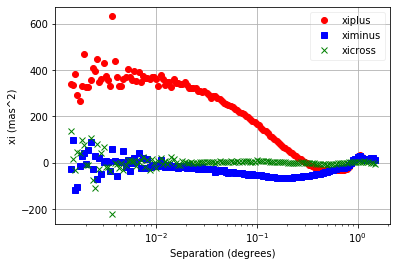

In [8]:
logr, xiplus, ximinus,xicross,junk = fa.vcorr(single)
# Let's plot them
r = np.exp(logr)
pl.semilogx(r,xiplus,'ro',label='xiplus')
pl.semilogx(r,ximinus,'bs',label='ximinus')
pl.semilogx(r,xicross,'gx',label='xicross')
pl.grid()
pl.xlabel('Separation (degrees)')
pl.ylabel('xi (mas^2)')
pl.legend(framealpha=0.3)

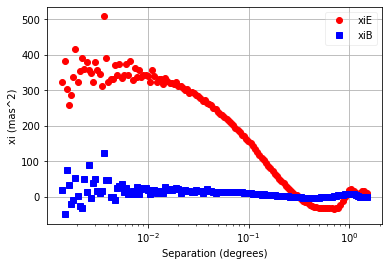

In [9]:
# Transform xi+- into E and B modes.  We should see the B mode be 
# near zero if the astrometric errors arise from atmospheric turbulence.
xiE, xiB = fa.xiEB(logr,xiplus,ximinus)
pl.semilogx(r,xiE,'ro',label='xiE')
pl.semilogx(r,xiB,'bs',label='xiB')
pl.grid()
pl.xlabel('Separation (degrees)')
pl.ylabel('xi (mas^2)')
pl.legend(framealpha=0.3)

*Hooray!* Next I will plot the xi+ function in 2d (i.e. not an azimuthal average like the above).  Here we can see that the correlation function is far from circular - the orientation is what we'd expect from the vector diagram above.

Length  17196


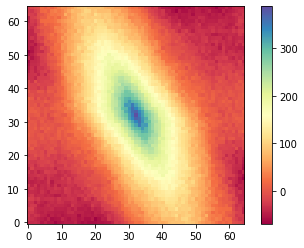

In [10]:
# I'll choose to have the largest plotted separation be 0.3 degrees,
# with 65 bins across the range in each direction
xiplus,cts = fa.vcorr2d(single,rmax=0.3,bins=65)
pl.imshow(xiplus,origin='lower',cmap='Spectral',interpolation='nearest')
pl.colorbar()

Finally, this routine uses a much faster method to just calculate the mean of dx\*dx, dx\*dy, and dy\*dy for pairs of measurements in this exposure that are within 0.02 degrees (1.2 arcmin) of each other.  nonzero value of <dx dy> and the inequality of the xx and yy terms is another statement of anisotropy, in this case that the typical error from turbulence is not isotropic either.

In [11]:
fa.covAnnulus(single,rMax=0.02)

(139.78155360158192, 209.62022210093323, 65.5121115931025, 60621)